# EDA bộ dataset PhoNER - Nhận diện các thực thể - liên quan đến COVID 19

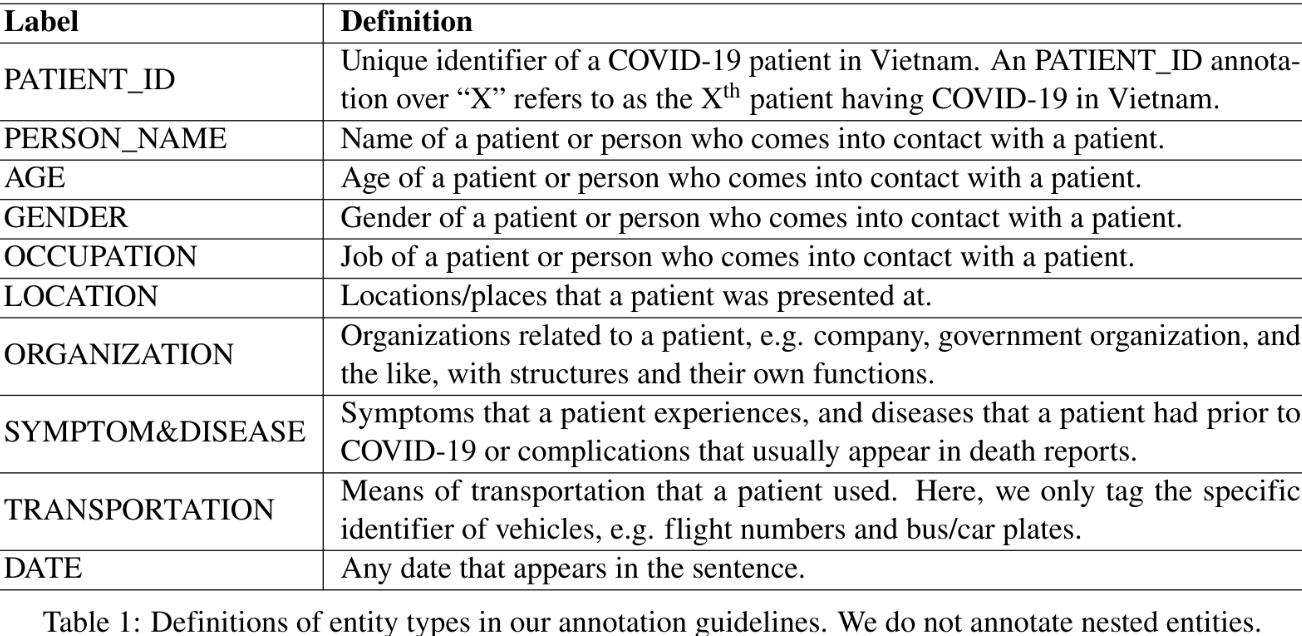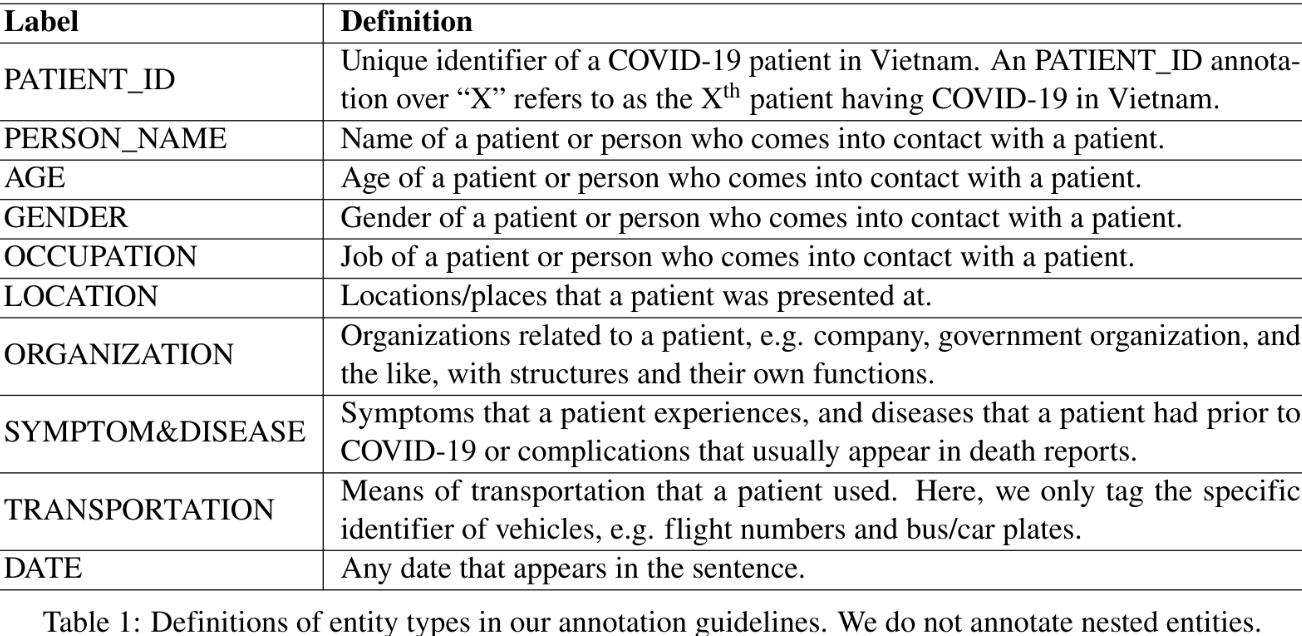

Tổng hợp ngắn gọn quy tắc gán nhãn cho **10 loại thực thể** dựa trên file Guideline:

### 1. PATIENT_ID (Mã bệnh nhân)
* **Chỉ gán phần số/mã:** Chỉ gán "X" trong cụm "Bệnh nhân X", "BN X".
* **Phạm vi:** Chỉ gán mã số cấp quốc gia (Việt Nam), không gán mã số cấp địa phương (Daklak, Hà Nội,...).
* **Dãy số:** Nếu liệt kê (BN 990-993), tách riêng từng mã, trường hợp này là (`990` và `993`).

### 2. NAME
* **Đối tượng:** Chỉ gán tên bệnh nhân (thường viết tắt) và người liên quan trực tiếp (tiếp xúc, lây nhiễm).
* **Loại trừ:**
    * Không gán danh xưng (ông, bà, anh, chị, giám đốc...).
    * **Không gán** tên bác sĩ điều trị, chuyên gia phát biểu, lãnh đạo báo cáo (trừ khi họ bị nhiễm hoặc là F1).

### 3. AGE
* **Chỉ gán con số:** Không gán từ "tuổi" đi kèm.
* **Đối tượng:** Phải gắn với một cá nhân cụ thể được định danh, ví dụ: Bệnh nhân 324, N.H.K 39 tuổi....

### 4. GENDER
* **Từ vựng:** Nam, nữ.
* **Đối tượng:** Phải gắn với một cá nhân cụ thể. Không gán các từ xưng hô ngụ ý giới tính (ông, bà, cô, chú).

### 5. JOB
* **Đối tượng:** Bệnh nhân và người tiếp xúc trực tiếp.
* **Bao gồm:** Học sinh, sinh viên, du học sinh.
* **Lưu ý:** Chỉ gán "chuyên gia" nếu có ngành nghề cụ thể (vd: chuyên gia dầu khí). Không gán từ viết tắt (nam sinh, nữ sinh). Ví dụ câu: "BN 378, Chuyên gia người Nam Phi, nhập cảnh Hà Nội" => `chuyên gia` ở đây không gán là thực thể.

### 6. LOCATION
* **Phạm vi:** Quốc gia, đơn vị hành chính, công trình công cộng (bệnh viện, sân bay), địa điểm thương mại.
* **Quy tắc gộp:** Gán thực thể dài nhất bao gồm cả đơn vị hành chính nhỏ và lớn (VD: "phường Hòa Cường Nam, quận Hải Châu, thành phố Đà Nẵng" là 3 thực thể riêng biệt nếu có dấu phẩy ngăn cách cấp bậc, nhưng "số 107 Nguyễn Đức Cảnh" là 1 thực thể).
* **Phân biệt với ORGANIZATION:** Nếu thực thể mang tính công cộng như (từng học ở trường A, từng đến bệnh viện B, thì gán là LOCATION). Nếu địa điểm chỉ nơi chốn (có giới từ "tại", "ở", "đến") -> gán **LOCATION**.

### 7. ORGANIZATION
* **Phạm vi:** Cơ quan chính phủ, bệnh viện, công ty, trường học.
* **Quy tắc xác định:**
    * Là chủ ngữ thực hiện hành động (thông báo, công bố, xét nghiệm).
    * Đi kèm chức vụ (Giám đốc Bệnh viện X -> Bệnh viện X là ORG).
* **Viết tắt:** Gán cả tên viết tắt (VD: HCDC).

### 8. DATE (Ngày tháng)
* **Định dạng:** Ngày/tháng, Ngày-tháng (VD: 15/3, 15-3).
* **Khoảng thời gian:** Gán riêng biệt ngày bắt đầu và kết thúc.

### 9. SYMPTOM_AND_DISEASE (Triệu chứng & Bệnh)
* **Bao gồm:** Triệu chứng COVID-19 và bệnh nền.
* **Gán cả:** Từ chỉ mức độ (mãn tính, giai đoạn cuối, sốt *cao*, đau họng *dữ dội*).
* **Loại trừ:** Không gán tác nhân gây bệnh (do virus), từ "biến chứng", từ phủ định (không ho), phương pháp điều trị (chạy thận).

### 10. TRANSPORTATION
* **Bắt buộc:** Phải có số hiệu cụ thể (Số hiệu chuyến bay VN0054, Biển số xe).
* **Loại trừ:** Không gán các từ chỉ phương tiện chung chung (máy bay, xe khách, taxi) nếu không có số hiệu.

### Quy tắc chung quan trọng:
1.  **Dài nhất (Longest Match):** Nếu thực thể chồng lấn, chọn cái dài nhất.
2.  **Dấu nối:** Nếu các thành phần ngăn cách bằng dấu phẩy (,), gạch ngang (-) -> Xem là 1 thực thể liền mạch (nếu cùng loại). Nếu ngăn cách bằng "của", "tại", "thuộc" -> Tách thành các thực thể riêng.

## B. EDA - thống kê

### 1. Đọc dữ liệu

In [1]:
def load_conll(file_path):
    """
    Đọc file .conll và trả về list các câu và list các nhãn tương ứng.
    """
    sentences = []
    tags = []
    
    current_sent = []
    current_tags = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            
            # Gặp dòng trắng (hoặc hết file) nghĩa là kết thúc 1 câu
            if not line:
                if len(current_sent) > 0:
                    sentences.append(current_sent)
                    tags.append(current_tags)
                    current_sent = []
                    current_tags = []
            else:
                # Tách từ và nhãn (cách nhau bởi space)
                parts = line.split()
                # "Bác_sĩ O" -> len=2
                
                if len(parts) >= 2:
                    word = parts[0]
                    tag = parts[-1] # Lấy phần tử cuối cùng làm tag
                    
                    current_sent.append(word)
                    current_tags.append(tag)
                    
    # Thêm câu cuối cùng nếu file không kết thúc bằng dòng trắng
    if len(current_sent) > 0:
        sentences.append(current_sent)
        tags.append(current_tags)
        
    return sentences, tags


In [2]:
import os

base_dir = './'
data_dir = os.path.join(base_dir, 'dataset/PhoNER-COVID19')
train_file = os.path.join(data_dir, 'train_word.conll')
dev_file = os.path.join(data_dir, 'dev_word.conll')
test_file = os.path.join(data_dir, 'test_word.conll')

train_sents, train_tags = load_conll(train_file)
dev_sents, dev_tags = load_conll(dev_file)
test_sents, test_tags = load_conll(test_file)

print(f"Số lượng câu train: {len(train_sents)}")
print(f"Câu train đầu tiên: {train_sents[0]}")

print(f"Số lượng unique nhãn train: {len(set(tag for tags in train_tags for tag in tags))}")

Số lượng câu train: 5027
Câu train đầu tiên: ['Đồng_thời', ',', 'bệnh_viện', 'tiếp_tục', 'thực_hiện', 'các', 'biện_pháp', 'phòng_chống', 'dịch_bệnh', 'COVID', '-', '19', 'theo', 'hướng_dẫn', 'của', 'Bộ', 'Y_tế', '.']
Số lượng unique nhãn train: 20


### 2. Kiểm tra cấu trúc dữ liệu

In [3]:
[print(train_sents[i]) for i in range(5)]

['Đồng_thời', ',', 'bệnh_viện', 'tiếp_tục', 'thực_hiện', 'các', 'biện_pháp', 'phòng_chống', 'dịch_bệnh', 'COVID', '-', '19', 'theo', 'hướng_dẫn', 'của', 'Bộ', 'Y_tế', '.']
['"', 'Số', 'bệnh_viện', 'có_thể', 'tiếp_nhận', 'bệnh_nhân', 'bị', 'sốt', 'cao', 'và', 'khó', 'thở', 'đang', 'giảm', 'dần', '"', ',', 'thông_cáo', 'có', 'đoạn', ',', 'cảnh_báo', 'những', 'bệnh_nhân', 'này', 'thay', 'vào', 'đó', 'được', 'chuyển', 'tới', 'các', 'phòng_khám', 'khẩn_cấp', ',', 'khiến', 'những', 'bệnh_nhân', 'mắc', 'bệnh', 'hiểm_nghèo', 'khác', 'không', 'có', 'cơ_hội', 'được', 'điều_trị', '.']
['Ngoài_ra', ',', 'những', 'người', 'tiếp_xúc', 'gián_tiếp', '(', 'đã', 'gặp', 'những', 'người', 'tiếp_xúc', 'gần', 'với', 'bệnh_nhân', ')', 'được', 'lập', 'danh_sách', 'và', 'yêu_cầu', 'cách_ly', 'y_tế', 'tại', 'nơi', 'ở', '.']
['Bà', 'này', 'khi', 'trở', 'về', 'quá_cảnh', 'Doha', '(', 'Qatar', ')', ',', 'đáp', 'xuống', 'Tân_Sơn_Nhất', 'sáng', '2/3', 'cùng', '75', 'hành_khách', ',', 'trong', 'đó', 'có', '55', 'ngườ

[None, None, None, None, None]

### 3. Thống kê số câu trong từng tập

In [9]:
print(f"Số lượng câu train: {len(train_sents)}")
print(f"Số lượng câu dev: {len(dev_sents)}")
print(f"Số lượng câu test: {len(test_sents)}")
print(train_sents[:2])

Số lượng câu train: 5027
Số lượng câu dev: 2000
Số lượng câu test: 3000
[['Đồng_thời', ',', 'bệnh_viện', 'tiếp_tục', 'thực_hiện', 'các', 'biện_pháp', 'phòng_chống', 'dịch_bệnh', 'COVID', '-', '19', 'theo', 'hướng_dẫn', 'của', 'Bộ', 'Y_tế', '.'], ['"', 'Số', 'bệnh_viện', 'có_thể', 'tiếp_nhận', 'bệnh_nhân', 'bị', 'sốt', 'cao', 'và', 'khó', 'thở', 'đang', 'giảm', 'dần', '"', ',', 'thông_cáo', 'có', 'đoạn', ',', 'cảnh_báo', 'những', 'bệnh_nhân', 'này', 'thay', 'vào', 'đó', 'được', 'chuyển', 'tới', 'các', 'phòng_khám', 'khẩn_cấp', ',', 'khiến', 'những', 'bệnh_nhân', 'mắc', 'bệnh', 'hiểm_nghèo', 'khác', 'không', 'có', 'cơ_hội', 'được', 'điều_trị', '.']]


In [17]:
print(f"Số lượng token trong train: {sum(len(s) for s in train_sents) }")
print(f"Số lượng token trong dev: {sum(len(s) for s in dev_sents)}")
print(f"Số lượng token trong test: {sum(len(s) for s in test_sents)}")
for s in train_sents[0]:
    print(s)

Số lượng token trong train: 132511
Số lượng token trong dev: 56283
Số lượng token trong test: 85678
Đồng_thời
,
bệnh_viện
tiếp_tục
thực_hiện
các
biện_pháp
phòng_chống
dịch_bệnh
COVID
-
19
theo
hướng_dẫn
của
Bộ
Y_tế
.


In [18]:
train_set = set(token for s in train_sents for token in s)
dev_set   = set(token for s in dev_sents for token in s)
test_set  = set(token for s in test_sents for token in s)

print(f"Số lượng từ vựng trong train: {len(train_set)}")
print(f"Số lượng từ vựng trong dev: {len(dev_set)}")
print(f"Số lượng từ vựng trong test: {len(test_set)}")

print(list(train_set)[:10])

Số lượng từ vựng trong train: 5241
Số lượng từ vựng trong dev: 4381
Số lượng từ vựng trong test: 5566
['liệu_trình', 'đặc_biệt', '796', '3.300', 'lại', '1045', 'm', 'nêu', 'Đông_Lễ', 'Nguyễn_Văn_Vĩnh_Châu']


In [19]:
matrix = [
    [len(train_set - train_set), len(train_set - dev_set),  len(train_set - test_set)],
    [len(dev_set   - train_set), len(dev_set - dev_set),   len(dev_set - test_set)],
    [len(test_set  - train_set), len(test_set - dev_set),  len(test_set - test_set)]
]

rows = ["train", "dev", "test"]

print("Ma trận số token KHÔNG xuất hiện ở tập kia")
for i, r in enumerate(rows):
    for j, c in enumerate(rows):
        print(f"{r} => not in {c}: {matrix[i][j]}")
    print()

Ma trận số token KHÔNG xuất hiện ở tập kia
train => not in train: 0
train => not in dev: 2132
train => not in test: 1686

dev => not in train: 1272
dev => not in dev: 0
dev => not in test: 1308

test => not in train: 2011
test => not in dev: 2493
test => not in test: 0



>Ta thấy số token có trong dev + test nhưng lại không có trong train khá lớn:
>
> dev có 4381 token unique, nhưng 1272 token chưa xuất hiện trong tập train (29% chưa xuất hiện trong train)
>
> test có 5566 token unique, nhưng có 2011 token chưa xuất hiện trong train (46% chưa xuất hiện trong dev)

=> điều này có thể gây ảnh hưởng lớn tới hiệu xuất mô hình, khi các từ chưa từng gặp sẽ bị gán UNK. Hiệu suất chắc chắn bị giảm so với việc biết từ đó, nhưng không có nghĩa là mô hình sẽ đoán sai 100% các từ <UNK>. Bởi khi dùng Bi-LSTM, thông tin ngữ cảnh sẽ được đọc từ 2 chiều, nên mô hình có xác suất đoán được ý nghĩa của từ <UNK>

### 4. Phân bố nhãn thực thể

In [20]:
print(f"Số lượng unique nhãn train: {len(set(tag for tags in train_tags for tag in tags))}")

Số lượng unique nhãn train: 20


Đề bài đưa ra 10 loại thực thể gán nhãn, tuy nhiên do có sự xuất hiện của các tiền tố như:

- 0 -> outside - token không thuộc thực thể nào
- B -> Begin - đại diện cho bắt đầu 1 thực thể
- i -> Inside - bên trong của thực thể

=> Nên theo lý thuyết ta sẽ có tối đa 21 nhãn (2 (Begin + Inside) x10 + 1 (outside)), nhưng ở trên ta chỉ tìm được 20 nhãn, điều này có thể do các word_segmentenced ở 1 số thực thể như `gender`/ `date`, `age` quá ngắn - chỉ có 1 token. Nên là bị thiếu mất nhãn `I-Inside`.

Sau đây ta sẽ kiểm tra nhãn nào bị thiếu.

In [21]:
# 1. Tạo danh sách tất cả các nhãn lý thuyết (21 nhãn)
entity_types = [
    "PATIENT_ID", "NAME", "AGE", "GENDER", "JOB", 
    "LOCATION", "ORGANIZATION", "DATE", 
    "SYMPTOM_AND_DISEASE", "TRANSPORTATION"
]
theoretical_tags = {'O'}
for entity in entity_types:
    theoretical_tags.add(f"B-{entity}")
    theoretical_tags.add(f"I-{entity}")

# 2. Lấy danh sách nhãn thực tế có trong tập train
# (Giả sử train_tags là list of list các nhãn của bạn)
actual_tags = set(tag for tags in train_tags for tag in tags)

# 3. Tìm nhãn bị thiếu
missing_tags = theoretical_tags - actual_tags

print(f"Số lượng nhãn lý thuyết: {len(theoretical_tags)}") # Nên là 21
print(f"Số lượng nhãn thực tế: {len(actual_tags)}")
print(f"Nhãn bị thiếu: {missing_tags}")

Số lượng nhãn lý thuyết: 21
Số lượng nhãn thực tế: 20
Nhãn bị thiếu: {'I-GENDER'}


Số lượng nhãn lý thuyết: 21
Số lượng nhãn thực tế: 20
Nhãn bị thiếu: {'I-GENDER'}
Nhãn bị thiếu là I-GENDER điều này về lý thuyết sẽ không ảnh hưởng đến dev/test vì giới tính thì chỉ nên có 1 từ (theo guideline annatation), ta sẽ không kiểm tra trên tập dev/ test vì làm vậy sẽ vi phạm quy tắc - dataleakage

## Thống kê số lần xuất hiện của từng nhãn

In [22]:
from collections import Counter

all_tags = [tag for tags in train_tags for tag in tags]
tag_counts = Counter(all_tags)

print(f"{'Tag':<30} {'Count'}")
print("-" * 40)
for tag, count in tag_counts.most_common():
    print(f"{tag:<30} {count}")

Tag                            Count
----------------------------------------
O                              104750
B-LOCATION                     5398
I-LOCATION                     5242
B-PATIENT_ID                   3240
B-DATE                         2549
I-ORGANIZATION                 2545
I-DATE                         2500
I-SYMPTOM_AND_DISEASE          1552
B-SYMPTOM_AND_DISEASE          1439
B-ORGANIZATION                 1137
B-AGE                          682
B-GENDER                       542
B-NAME                         349
B-TRANSPORTATION               226
B-JOB                          205
I-TRANSPORTATION               67
I-JOB                          62
I-NAME                         13
I-PATIENT_ID                   11
I-AGE                          2


C:\Users\Admin\AppData\Local\Temp\ipykernel_14992\1830677761.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_tags, x='Tag', y='Count', palette='viridis')


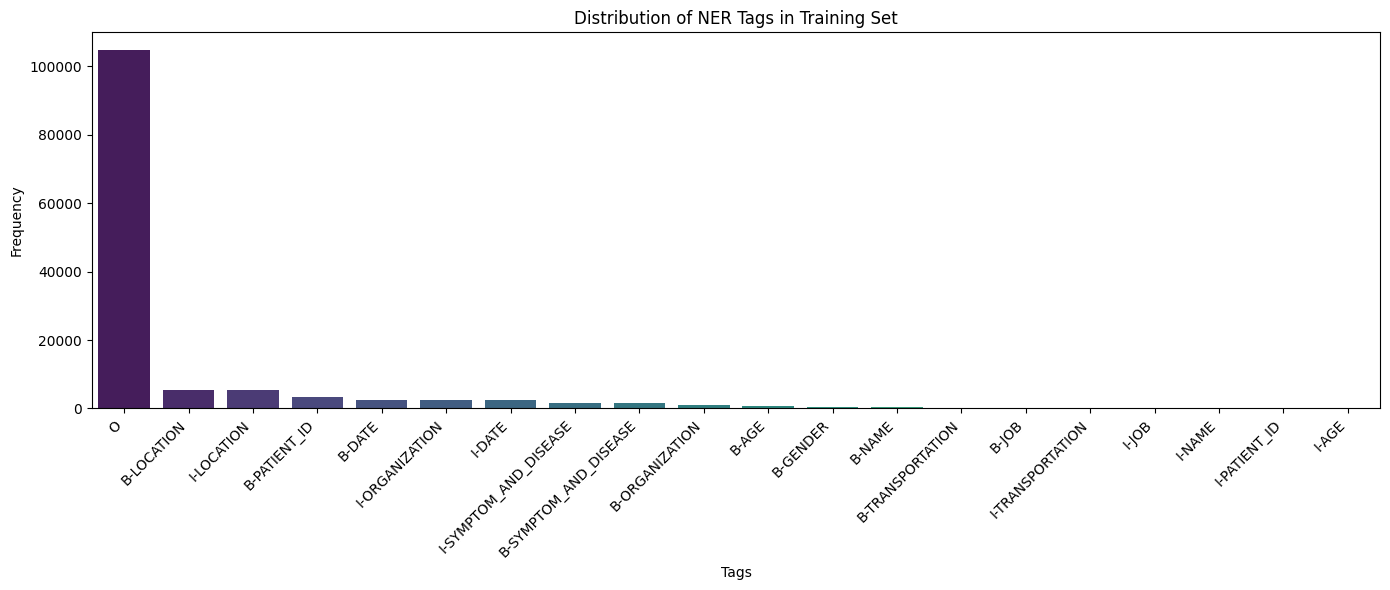

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df_tags = pd.DataFrame(tag_counts.most_common(), columns=['Tag', 'Count'])

plt.figure(figsize=(14, 6))
sns.barplot(data=df_tags, x='Tag', y='Count', palette='viridis')
plt.title("Distribution of NER Tags in Training Set")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Nhãn xuất hiện nhiều nhất là O - outside | Ngoài ra trong các nhãn thực thể thì `B-location và I-location` xuất hiện nhiều nhất. 

Nhãn không xuất hiện là `I-gender` ngoài ra các nhãn thường có 1 token như AGE, PATIENT_ID, NAME nên các nhãn này cho tiền tố I - Inside rất ít xuất hiện

### 4. Phân tích độ dài câu

Min length: 6
Max length: 161
Mean length: 26.36


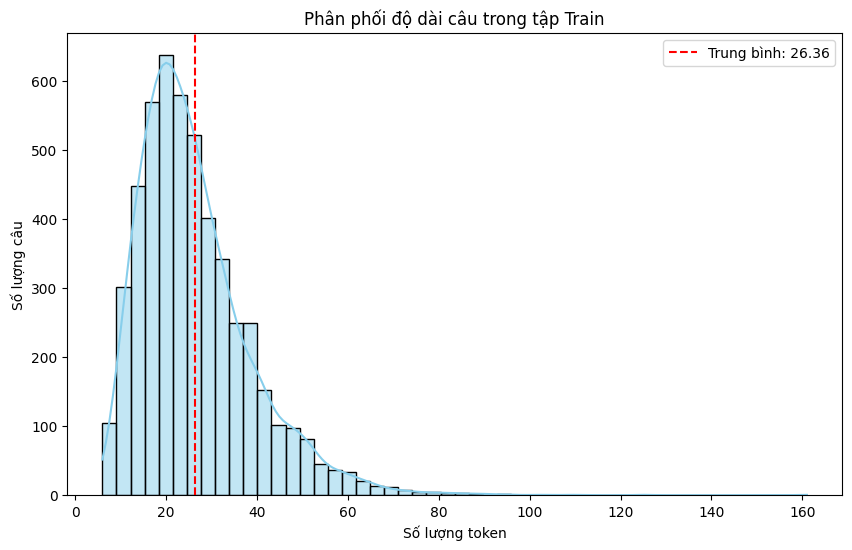

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tính độ dài (số token) cho từng câu
sent_lengths = [len(s) for s in train_sents]

# Tính các chỉ số thống kê cơ bản
min_len = np.min(sent_lengths)
max_len = np.max(sent_lengths)
mean_len = np.mean(sent_lengths)

print(f"Min length: {min_len}")
print(f"Max length: {max_len}")
print(f"Mean length: {mean_len:.2f}")

# Vẽ biểu đồ Histogram
plt.figure(figsize=(10, 6))
sns.histplot(sent_lengths, bins=50, kde=True, color='skyblue', edgecolor='black')
plt.title('Phân phối độ dài câu trong tập Train')
plt.xlabel('Số lượng token')
plt.ylabel('Số lượng câu')
# Vẽ đường trung bình để dễ quan sát
plt.axvline(mean_len, color='red', linestyle='dashed', linewidth=1.5, label=f'Trung bình: {mean_len:.2f}')
plt.legend()
plt.show()

Mặc dù LSTM (Long Short-Term Memory) sinh ra để khắc phục điểm yếu của RNN truyền thống, nhưng nó vẫn gặp khó khăn với các chuỗi quá dài:

- Vanishing Gradient: Dù LSTM giảm thiểu được vấn đề này tốt hơn RNN, nhưng với các chuỗi rất dài (ví dụ > 100-200 bước), khả năng truyền tải thông tin (context) từ đầu câu xuống cuối câu vẫn bị suy giảm. BiLSTM sẽ khó học được mối quan hệ phụ thuộc xa.
- Padding: việc chọn max_length lớn, lưu trữ được nhiều thông tin, nhưng lại thêm quá nhiều số 0, gây chậm hội tụ gradient.

Sau đây ta sẽ đi tìm ra max_length tối ưu

In [25]:
import numpy as np

# Tính giá trị phân vị thứ 99 của độ dài câu
max_len_99 = np.percentile(sent_lengths, 99)

print(f"Độ dài ở phân vị 99%: {max_len_99}")
print(f"Số lượng câu bị cắt nếu chọn max_len={int(max_len_99)}: {sum(l > max_len_99 for l in sent_lengths)}")
print(f"Kiến nghị max_len cho padding: {int(max_len_99)}")

Độ dài ở phân vị 99%: 65.0
Số lượng câu bị cắt nếu chọn max_len=65: 48
Kiến nghị max_len cho padding: 65


Ta sẽ thử in ra các từ quá dài để xem chúng rút cuộc là gì, từ đó quyết định:

- Trường hợp 1 (Rác/Lỗi): Nếu câu dài là do lỗi tách câu (ví dụ 2-3 câu dính liền nhau không có dấu chấm), thì việc cắt bỏ hoặc tách lại là bắt buộc. Đây là nhiễu làm hại mô hình.

- Trường hợp 2 (Câu phức hợp): Nếu là văn bản hành chính, pháp luật, liệt kê dài... việc cắt ở từ thứ 65 có thể làm mất thực thể ở phía sau.

In [26]:
# Tìm index của các câu dài hơn ngưỡng 65
long_sent_indices = [i for i, sent in enumerate(train_sents) if len(sent) > 65]

# Sắp xếp để lấy các câu dài nhất trong nhóm này
long_sent_indices.sort(key=lambda i: len(train_sents[i]), reverse=True)

print(f"Tổng số câu vượt quá ngưỡng 65: {len(long_sent_indices)}")

# In thử 5 câu dài nhất để xem nội dung (quan sát xem có phải lỗi dính câu không)
for i in range(min(5, len(long_sent_indices))):
    idx = long_sent_indices[i]
    sent_len = len(train_sents[idx])
    content = " ".join(train_sents[idx])
    
    print(f"Câu index {idx} (Độ dài: {sent_len} token):")
    print(f"Nội dung: {content}")
    print("-" * 20)

Tổng số câu vượt quá ngưỡng 65: 48
Câu index 1416 (Độ dài: 161 token):
Nội dung: Trong ngày , có 53 bệnh_nhân được công_bố khỏi bệnh , gồm 19 bệnh_nhân tại Bệnh_viện Bệnh nhiệt_đới trung_ương cơ_sở 2 ( bệnh_nhân 364 , 527 , 528 , 529 , 530 , 531 , 532 , 533 , 534 , 535 , 538 , 539 , 540 , 541 , 542 , 543 , 545 , 546 , 670 ) ; 23 bệnh_nhân tại Trung_tâm Y_tế huyện Hoà_Vang ( bệnh_nhân 457 , 490 , 505 , 554 , 584 , 586 , 606 , 633 , 657 , 686 , 690 , 694 , 724 , 726 , 732 , 733 , 734 , 735 , 757 , 766 , 770 , 784 , 825 ) , 5 bệnh_nhân tại Bệnh_viện Đa_khoa trung_ương Quảng_Nam ( bệnh_nhân 433 , 622 , 643 , 773 , 834 ) và 6 bệnh_nhân tại Bệnh_viện Đa_khoa khu_vực tỉnh Quảng_Nam ( bệnh_nhân 519 , 549 , 551 , 563 , 564 , 616 ) .
--------------------
Câu index 2973 (Độ dài: 125 token):
Nội dung: Năm yêu_cầu của Chủ_tịch TP Hà_Nội Ngay sau khi Bộ Y_tế xác_định bệnh_viện Bạch_Mai là ổ dịch , Chủ_tịch UBND thành_phố Hà_Nội Nguyễn_Đức_Chung yêu_cầu : Thứ nhất , chủ_tịch UBND quận , huyện , thị_x

Các câu trên đa phần mang nhiều ý nghĩa, câu 1416 dài nhất, lý do là đang liệt kê số hiệu bệnh nhân, đây vẫn được gán nhãn là một thực thể. Các câu sau đa phần thuộc văn bản hành chính, báo cáo vẫn mang ý nghĩa lớn.

=> Ta nên chọn max_length là `126`, chỉ bỏ 1 câu dài nhất, để không làm mất thông tin của 48 câu (khi chọn max_length là 65)